# Evaluations: Electron Density and Related Properties

[`gbasis`](http://gbasis.qcdevs.org/intro.html) supports the evaluation of the electron density and its most commonly used derived properties at any set of points in space. To evaluate properties dependent on the system state, we need its wavefunction or an equivalent representation. In `gbasis`, this is done through the **one-electron reduced density matrix** (1-RDM). As a case example, the following code will load this data from a `fchk` file corresponding to a `ub3lyp/aug-cc-pvtz` calculation on formaldehyde. The file can be [downloaded]() from the data folder of this repository. For simplicity, we will be using the [`iodata`](https://iodata.readthedocs.io/en/latest/) package to load the data:

In [1]:
import numpy as np
from iodata import load_one
from gbasis.wrappers import from_iodata

# formchk file available from
#

# load molecule info and basis from fchk file
mol_data = load_one("./data/ch2o_q_0.fchk")
ao_basis = from_iodata(mol_data)  # basis definition for the atomic orbitals

# one electron RDM from fchk file
rdm = mol_data.one_rdms["scf"]

# atomic coordinates and numbers
atcoords = mol_data.atcoords
atnums = mol_data.atnums

print(f"Loaded: {mol_data.title}")
print(f"Basis: {mol_data.obasis_name}")
print(f"Atom numbers: {mol_data.atnums}")
print(f"Atom coordinates:\n{mol_data.atcoords}")
print(f"Molecule is planar: {np.allclose(atcoords[:, 2], 0 , atol=1e-6)}")
print(f"Number of atomic orbitals: {len(ao_basis)}")
print(f"One electron RDM shape: {rdm.shape}")

Loaded: ch2o_q+0 ub3lyp/aug-cc-pvtz opt-stable-freq
Basis: aug-cc-pvtz
Atom numbers: [8 6 1 1]
Atom coordinates:
[[ 2.27823914e+00  4.13899085e-07  3.12033662e-07]
 [ 1.01154892e-02  1.09802629e-07 -6.99333116e-07]
 [-1.09577141e+00  1.77311416e+00  1.42544321e-07]
 [-1.09577166e+00 -1.77311468e+00  2.44755133e-07]]
Molecule is planar: True
Number of atomic orbitals: 46
One electron RDM shape: (138, 138)


## Define Auxiliary Grid

The loaded system is planar and all of its atoms lie on the xy plane (z=0) in this specific file. For simplicity, we will perform all successive analysis on the xy plane. 

In [2]:
# Sample n points uniformly along x and y axes within [-coord_limit, coord_limit]
coord_limit = 5
plt_pts = 40
plt_lmts = [-coord_limit, coord_limit, -coord_limit, coord_limit]
x_vals = np.linspace(-coord_limit, coord_limit, plt_pts)
y_vals = x_vals

# Sample 3D points uniformly in the molecular xy-plane (z=0)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
x_vals, y_vals = x_vals.flatten(), y_vals.flatten()
z_vals = np.zeros_like(x_vals)
points = np.array([x_vals, y_vals, z_vals]).T # gbasis evaluates at 3D points

print("Grid for evaluating the density matrix has shape: ", points.shape)
print(f"Distance between grid points: {2*coord_limit/(plt_pts-1)}")


Grid for evaluating the density matrix has shape:  (1600, 3)
Distance between grid points: 0.2564102564102564


## Evaluation of Density-Related Properties

### Electron Density

The electron density 
$$\rho(\mathbf{r}_n) = \sum_{ij} \gamma_{ij} \phi_i(\mathbf{r}_n) \phi_j(\mathbf{r}_n)$$

is the most basic property that can be evaluated from the 1-RDM and can be evaluated at an array of points using the [`evaluate_density`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_density) function. 

In the following example, we will evaluate and plot the electron density and its gradient on the molecular plane.

Electron density shape: (1600,)
Electron density is positive definite: True


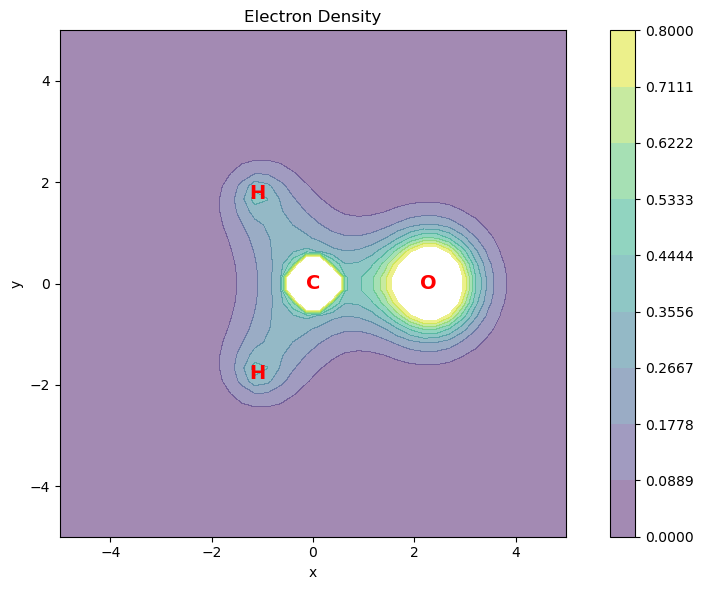

In [3]:
import matplotlib.pyplot as plt
from gbasis.evals.density import evaluate_density

# Compute expected electron density using GBasis
rho = evaluate_density(rdm, ao_basis, points)
print(f"Electron density shape: {rho.shape}")
print(f"Electron density is positive definite: {np.all(rho >= 0)}")

# plot the electron density
fig=plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect='equal')
# Plot the electron density as contour plot
ax1.set_title("Electron Density")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = rho.reshape(plt_pts, plt_pts)
# Add contour plot of the electron density
plt.contourf(X, Y, Z, 10, cmap='viridis', alpha=0.5, levels=np.linspace(0, 0.8, 10))
plt.colorbar()

# Add atomic symbols to the plots
symbols = ['O', 'C', 'H', 'H']
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Gradient of the Electron Density

`gbasis` also supports the evaluation of the gradient of the electron density. 

$$
\begin{equation*}
  \nabla \rho(\mathbf{r}_n)
  =
  \begin{bmatrix}
    \frac{\partial}{\partial x} \rho(\mathbf{r}_n)\\\\
    \frac{\partial}{\partial y} \rho(\mathbf{r}_n)\\\\
    \frac{\partial}{\partial z} \rho(\mathbf{r}_n)
  \end{bmatrix}\\
\end{equation*}
$$

This can be evaluated in a grid of points  using the [`evaluate_density_gradient`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_density_gradient).

The following example shows how to evaluate the gradient of the electron density and plot it on the molecular plane. The gradient is represented as a vector field, where the length of the arrows in the representation fixed and the color represents the magnitude of the gradient.

Shape of the gradient of the electron density: (1600, 3) (npoints, 3)


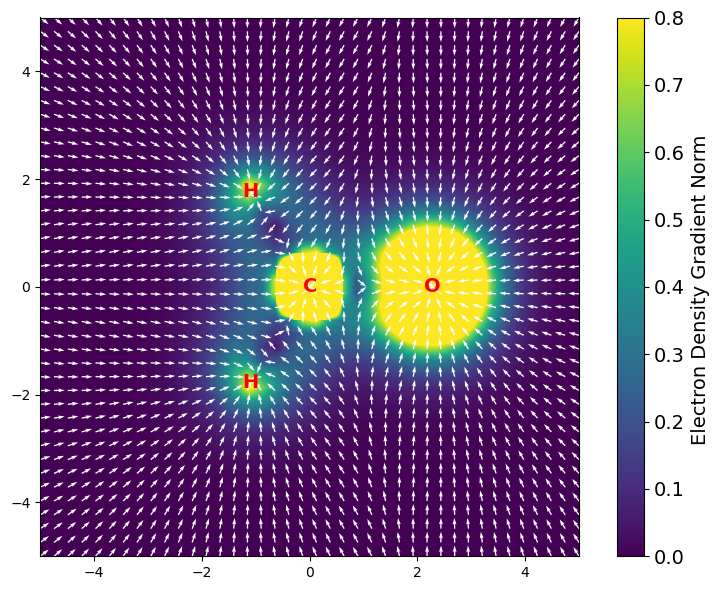

In [4]:
from gbasis.evals.density import evaluate_density_gradient

# compute the gradient of the electron density
rho_grad = evaluate_density_gradient(rdm, ao_basis, points)
print(f"Shape of the gradient of the electron density: {rho_grad.shape} (npoints, 3)")

#plot the gradient of the electron density
rho_grad_norm = np.linalg.norm(rho_grad, axis=1)

# use fixed length for the gradient vectors
grad_length = 0.2
rho_grad_sc = rho_grad/np.linalg.norm(rho_grad, axis=1)[:, None] * grad_length

fig=plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, aspect='equal')

# Plot the interpolated electron density as a 2D heatmap with specified color scale limits
heatmap = ax1.imshow(rho_grad_norm.reshape(plt_pts,plt_pts), cmap="viridis", interpolation="bilinear", extent=plt_lmts, vmin=0, vmax=0.8)
cbar = plt.colorbar(heatmap, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Electron Density Gradient Norm ", fontsize=14) 

# Plot the vectorial map (omit the z-component) of the analytical gradient
ax1.quiver(points[:, 0], points[:, 1], rho_grad_sc[:, 0], rho_grad_sc[:, 1], color='w', angles='xy', scale_units='xy', scale=1)

# Adjust the limits to fit your data and set labels and title
# Add atomic symbols to the plots
symbols = ['O', 'C', 'H', 'H']
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Hessian of the Electron Density

The hessian of the electron density is defined as:

$$
\begin{equation*}
  H[\rho(\mathbf{r}_n)]
  =
  \begin{bmatrix}
    \frac{\partial^2}{\partial x^2} \rho(\mathbf{r}_n) &
    \frac{\partial^2}{\partial x \partial y} \rho(\mathbf{r}_n) &
    \frac{\partial^2}{\partial x \partial z} \rho(\mathbf{r}_n)\\\\
    \frac{\partial^2}{\partial x \partial y} \rho(\mathbf{r}_n) &
    \frac{\partial^2}{\partial y^2} \rho(\mathbf{r}_n)&
    \frac{\partial^2}{\partial y \partial z} \rho(\mathbf{r}_n)\\\\
    \frac{\partial^2}{\partial x \partial z} \rho(\mathbf{r}_n) &
    \frac{\partial^2}{\partial z^2} \rho(\mathbf{r}_n)&
    \frac{\partial^2}{\partial x \partial z} \rho(\mathbf{r}_n)\\
  \end{bmatrix}\\
\end{equation*}
$$

This property is also supported by `gbasis` and is widely used in the study of molecular properties. For example, the electron density $\rho(\mathbf{r})$, its gradient $\nabla \rho(\mathbf{r})$ and the hessian $H[\rho(\mathbf{r})]$  are all the required elements to perform an analysis of the critical points of the electron density.

This property can be evaluated in a grid of points  using the [`evaluate_density_hessian`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_density_hessian).

In [5]:
from gbasis.evals.density import evaluate_density_hessian

rho_hess = evaluate_density_hessian(rdm, ao_basis, points)

print(f"The hessians have shape {rho_hess.shape}")
print(f"  - The first index is the point index: {rho_hess.shape[0]} points" )
print(f"  - The second are the x, y, z derivative components of the hessian: {rho_hess.shape[1]} components" )
print(f"  - The third is the x, y, z derivative components of the hessian: {rho_hess.shape[2]} components" )
print(f"The hessians are symmetric: {np.allclose(rho_hess, rho_hess.transpose(0, 2, 1))}")

The hessians have shape (1600, 3, 3)
  - The first index is the point index: 1600 points
  - The second are the x, y, z derivative components of the hessian: 3 components
  - The third is the x, y, z derivative components of the hessian: 3 components
The hessians are symmetric: True


### Laplacian of the Electron Density

The Laplacian of the electron density $\nabla\rho(r)$ corresponds to the trace of the Hessian of $\rho$ and is an important property commonly used in the analysis of chemical bonding.

$$
\begin{equation*}
  \nabla^2 \rho(\mathbf{r}_n)
  =
  \frac{\partial^2}{\partial x^2} \rho(\mathbf{r}_n)
  + \frac{\partial^2}{\partial y^2} \rho(\mathbf{r}_n)
  + \frac{\partial^2}{\partial z^2} \rho(\mathbf{r}_n)
\end{equation*}
$$

  - A positive Laplacian indicates a region of space where the kinetic energy density is dominant and charge is depleted.
  - A negative Laplacian indicates a region of space where the potential energy is dominant and charge is accumulated.

The Laplacian can be used then to understand the formation of chemical bonds, for example, by pairing regions of negative Laplacian from the base with regions of positive Laplacian from the acid. This property can be evaluated using the [`evaluate_density_laplacian`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_density_laplacian) function. The following example shows how to evaluate the Laplacian of the electron density and plot it on the molecular plane. The Laplacian is represented as a scalar field, where the color represents the magnitude of the Laplacian.

Laplacian of the Electron Density have shape (1600,) (one value per point)


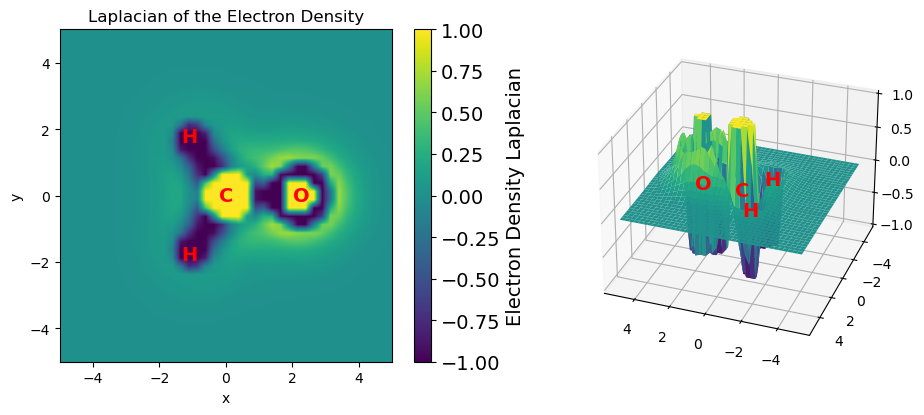

In [6]:
from gbasis.evals.density import evaluate_density_laplacian

# compute the Laplacian of the electron density
rho_lapl = evaluate_density_laplacian(rdm, ao_basis, points)
print(f"Laplacian of the Electron Density have shape {rho_lapl.shape} (one value per point)")

# plot the Laplacian of the electron density
fig=plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121, aspect='equal')
ax1.set_title("Laplacian of the Electron Density")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = rho_lapl.reshape(plt_pts, plt_pts)
Z[Z > 1] = 1
Z[Z < -1] = -1

heatmap = ax1.imshow(Z, cmap="viridis", interpolation="bilinear", extent=plt_lmts, vmin=-1, vmax=1)
cbar = plt.colorbar(heatmap, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Electron Density Laplacian", fontsize=14) 

ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(X, Y, Z, cmap='viridis', vmax=1, vmin=-1, linewidth=0.5, antialiased=True)
ax2.set_zlim(-1, 1)
ax2.view_init(30, 110, 0)

# Add atomic symbols to the plots
symbols = ['O', 'C', 'H', 'H']
xy_coords = atcoords[:, :2]
for coord, symbol in zip(atcoords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')
    ax2.text(coord[0], coord[1], coord[2], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Positive Definite Kinetic Energy Density

The positive definite kinetic energy density is defined as the sum of the diagonal elements of the kinetic energy density matrix.

\begin{align*}
t_+ (\mathbf{r}_n)
        &= \frac{1}{2} \left.
          \nabla_{\mathbf{r}} \cdot \nabla_{\mathbf{r}'} \gamma(\mathbf{r}, \mathbf{r}')
        \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}\\
        &= \frac{1}{2} \left(
          \frac{\partial^2}{\partial x \partial x'} \gamma(\mathbf{r}, \mathbf{r}')
          + \frac{\partial^2}{\partial y \partial y'} \gamma(\mathbf{r}, \mathbf{r}')
          + \frac{\partial^2}{\partial z \partial z'} \gamma(\mathbf{r}, \mathbf{r}')
        \right)_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}
\end{align*}

This is a property commonly used in conceptual density functional theory. This property can be evaluated using the [`evaluate_positive_definite_kinetic_energy`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_posdef_kinetic_energy_density) function, and is closely related to the [`general kinetic energy density`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=kinetic#gbasis.evals.density.evaluate_general_kinetic_energy_density)

$$t_{\alpha} (\mathbf{r}_n) = t_+(\mathbf{r}_n) + \alpha \nabla^2 \rho(\mathbf{r}_n)$$

 which can be evaluated in a similar way.
 
 The following example shows how to evaluate the positive definite kinetic energy density and plot it on the molecular plane. The positive definite kinetic energy density is represented as a scalar field, where the color represents the magnitude of the positive definite kinetic energy density.

The kinetic energy density has shape (1600,) (one value per point)
The kinetic energy density is positive definite: True


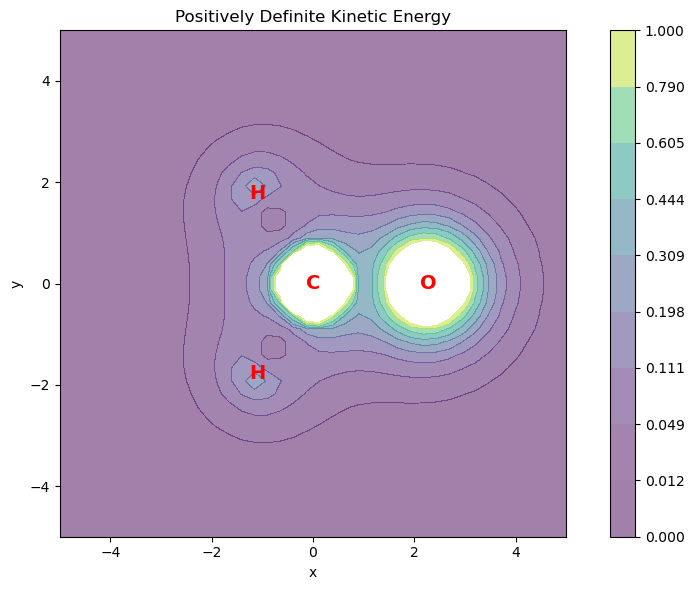

In [7]:
from gbasis.evals.density import evaluate_posdef_kinetic_energy_density

# Compute expected electron density using GBasis
k_vals = evaluate_posdef_kinetic_energy_density(rdm, ao_basis, points)

print(f"The kinetic energy density has shape {k_vals.shape} (one value per point)")
print(f"The kinetic energy density is positive definite: {np.all(k_vals >= 0)}")

# plot the electron density
fig=plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect='equal')
# Plot the electron density as contour plot
ax1.set_title("Positively Definite Kinetic Energy")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = k_vals.reshape(plt_pts, plt_pts)
# Add contour plot of the electron density
plt.contourf(X, Y, Z, 10, cmap='viridis', alpha=0.5, levels=np.linspace(0, 1, 10) ** 2, vmin=0, vmax=1)
plt.colorbar()

# Add atomic symbols to the plots
symbols = ['O', 'C', 'H', 'H']
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Arbitrary Derivatives of Density

`gbasis` also supports the evaluation of arbitrary derivatives of the electron density.

$$\frac{\partial^{L_x + L_y + L_z}}{\partial x^{L_x} \partial y^{L_y} \partial z^{L_z}}
  \rho(\mathbf{r}_n)
  =
  \sum_{l_x=0}^{L_x} \sum_{l_y=0}^{L_y} \sum_{l_z=0}^{L_z}
  \binom{L_x}{l_x} \binom{L_y}{l_y} \binom{L_z}{l_z}
  \sum_{ij} \gamma_{ij}
  \frac{\partial^{l_x + l_y + l_z} \rho(\mathbf{r}_n)}{\partial x^{l_x} \partial y^{l_y} \partial z^{l_z}}
  \frac{
    \partial^{L_x + L_y + L_z - l_x - l_y - l_z} \rho(\mathbf{r}_n)
  }{
    \partial x^{L_x - l_x} \partial y^{L_y - l_y} \partial z^{L_z - l_z}
  }$$
  

This is done using the [`evaluate_deriv_density`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_deriv_density) function from the 1-RDM and an array with the orders (x,y,z) of the derivative. The following example shows how to evaluate the derivative of the electron density and plot it on the molecular plane. The derivative is represented as a scalar field, where the color represents the magnitude of the derivative. In the following example, we use the [`evaluate_deriv_density`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_deriv_density) function to reconstruct the gradient, Hessian and Laplacian of the electron density.

In the example code cell below, presume the following derivative of the density is desired:

$$\frac{\partial ^{3}}{\partial x \partial y^{2}}$$

In [8]:
from gbasis.evals.density import evaluate_deriv_density

print("Reconstructing the gradient using derivatives")
# evaluate the derivative of density (with respect to x, y, z).
rho_deriv_x = evaluate_deriv_density(np.array([1, 0, 0]), rdm, ao_basis, points)
rho_deriv_y = evaluate_deriv_density(np.array([0, 1, 0]), rdm, ao_basis, points)
rho_deriv_z = evaluate_deriv_density(np.array([0, 0, 1]), rdm, ao_basis, points)

rho_grad_reconstructed = np.array([rho_deriv_x, rho_deriv_y, rho_deriv_z]).T
print(f"Shape of the gradient of the electron density: {rho_grad.shape}")
print(f"Shape of the reconstructed gradient of the electron density: {rho_grad_reconstructed.shape}")
print(f"Reconstructed and original gradients equal: {np.allclose(rho_grad, rho_grad_reconstructed)}")

print("\nReconstructing the hessian using derivatives")
rho_deriv_xx = evaluate_deriv_density(np.array([2, 0, 0]), rdm, ao_basis, points)
rho_deriv_yy = evaluate_deriv_density(np.array([0, 2, 0]), rdm, ao_basis, points)
rho_deriv_zz = evaluate_deriv_density(np.array([0, 0, 2]), rdm, ao_basis, points)
rho_deriv_xy = evaluate_deriv_density(np.array([1, 1, 0]), rdm, ao_basis, points)
rho_deriv_xz = evaluate_deriv_density(np.array([1, 0, 1]), rdm, ao_basis, points)
rho_deriv_yz = evaluate_deriv_density(np.array([0, 1, 1]), rdm, ao_basis, points)

rho_hess_reconstructed = np.array([[rho_deriv_xx, rho_deriv_xy, rho_deriv_xz],
                                    [rho_deriv_xy, rho_deriv_yy, rho_deriv_yz],
                                    [rho_deriv_xz, rho_deriv_yz, rho_deriv_zz]]).transpose(2,1,0)
print(f"Shape of the hessian of the electron density: {rho_hess.shape}")
print(f"Shape of the reconstructed hessian of the electron density: {rho_hess_reconstructed.shape}")
print(f"Reconstructed and original hessians equal: {np.allclose(rho_hess, rho_hess_reconstructed)}")

Reconstructing the gradient using derivatives
Shape of the gradient of the electron density: (1600, 3)
Shape of the reconstructed gradient of the electron density: (1600, 3)
Reconstructed and original gradients equal: True

Reconstructing the hessian using derivatives
Shape of the hessian of the electron density: (1600, 3, 3)
Shape of the reconstructed hessian of the electron density: (1600, 3, 3)
Reconstructed and original hessians equal: True
